

## Task 2: Predictive modeling of customer bookings



In [88]:
# imports 
import pickle 
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
from pycaret.classification import *
# Model Buidling and metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.model_selection import cross_val_score

In [63]:
#load the dataset 
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

#### The First Look at Data Variables 
To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking



In [30]:
# separate numerical features and  categorical features 
cat_features = df.select_dtypes(include="object").columns
num_features = df.select_dtypes(include=np.number).columns
# check values of each categorical column  
for col in cat_features:
    print(f"Column {col} Has Values {df[col].unique()}", end="\n")
    print("^"*100)

Column sales_channel Has Values ['Internet' 'Mobile']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Column trip_type Has Values ['RoundTrip' 'CircleTrip' 'OneWay']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Column flight_day Has Values ['Sat' 'Wed' 'Thu' 'Mon' 'Sun' 'Tue' 'Fri']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Column route Has Values ['AKLDEL' 'AKLHGH' 'AKLHND' 'AKLICN' 'AKLKIX' 'AKLKTM' 'AKLKUL' 'AKLMRU'
 'AKLPEK' 'AKLPVG' 'AKLTPE' 'AORICN' 'AORKIX' 'AORKTM' 'AORMEL' 'BBIMEL'
 'BBIOOL' 'BBIPER' 'BBISYD' 'BDOCTS' 'BDOCTU' 'BDOHGH' 'BDOICN' 'BDOIKA'
 'BDOKIX' 'BDOMEL' 'BDOOOL' 'BDOPEK' 'BDOPER' 'BDOPUS' 'BDOPVG' 'BDOSYD'
 'BDOTPE' 'BDOXIY' 'BKICKG' 'BKICTS' 'BKICTU' 'BKIHND' 'BKIICN' 'BKIKIX'
 'BKIKTM' 'BKIMEL' 'BKIMRU' 'BKIOOL' 'BKIPEK' 'BKIPER' 'BKIPUS' 'BKIPVG'
 'BKISYD' 'BKIXIY' 'BLRICN' 'BLRMEL' 'BLRPER

In [65]:
# encode flight days into 
map_days = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(map_days).astype("int64")
# show 
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [32]:
#show summary statstics for numerical features 
df.describe(include="number")

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [33]:
#show summary statstics for categorical features 
df.describe(include="object")

,sales_channel,trip_type,route,booking_origin
count,50000,50000,50000,50000
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,44382,49497,2680,17872


In [90]:
# check data balance
df['booking_complete'].value_counts(normalize=True)

0    0.85044
1    0.14956
Name: booking_complete, dtype: float64

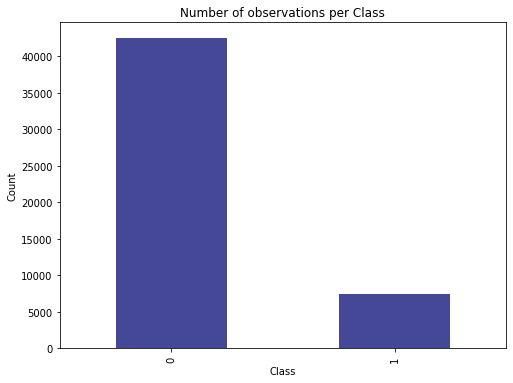

In [66]:
#plot target variable frequency plot 
plt.figure(figsize=(8,6))
df['booking_complete'].value_counts().plot(kind='bar', color="#454896")
plt.title("Number of observations per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The data is obviously imbalanced. We will aplly the SMOTE method to balance the dataset before training our machine learning models

### AutoML for Predictive Modeling

In [67]:
train = df.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = df.drop(train.index).reset_index(drop=True)

print('Data for Modeling: ' + str(train.shape))
print('Unseen Data For Predictions: ' + str(test.shape))

Data for Modeling: (40000, 14)
Unseen Data For Predictions: (10000, 14)


In [68]:
# re-update categorical and numerical features
cat_features = list(df.select_dtypes(include="object").columns)
num_features = list(df.select_dtypes(include=np.number).columns)[:-1]

In [75]:
# setup the training settings for Pycaret 
setup = setup(data = train, target = 'booking_complete', session_id=101, 
              categorical_features= cat_features, numeric_features=num_features, 
              remove_multicollinearity=True, remove_outliers=True, 
              normalize=True, feature_selection=True, fix_imbalance=True) 

Setup Succesfully Completed!


,Description,Value
0,session_id,101
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(40000, 14)"
4,Missing Values,False
5,Numeric Features,9
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [76]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8464,0.7736,0.1711,0.4647,0.2498,0.1841,0.2130,0.8545
1,CatBoost Classifier,0.8464,0.7752,0.1432,0.4594,0.2179,0.1580,0.1917,33.7157
2,Extreme Gradient Boosting,0.8408,0.7667,0.1764,0.4267,0.2492,0.1768,0.1989,12.3964
3,Random Forest Classifier,0.8307,0.7217,0.2097,0.3821,0.2706,0.1839,0.1947,0.8108
4,Extra Trees Classifier,0.8242,0.7488,0.2424,0.3680,0.2921,0.1966,0.2023,10.9893
5,Gradient Boosting Classifier,0.8130,0.7469,0.3121,0.3571,0.3329,0.2248,0.2256,21.3369
6,Decision Tree Classifier,0.7803,0.5927,0.3250,0.2907,0.3068,0.1768,0.1772,1.2502
7,Ada Boost Classifier,0.7545,0.7342,0.5278,0.3116,0.3916,0.2505,0.2643,7.9009
8,Logistic Regression,0.7122,0.7691,0.7027,0.3021,0.4224,0.2695,0.3120,2.2564
9,Ridge Classifier,0.7067,0.0000,0.7061,0.2980,0.4190,0.2640,0.3080,0.4370


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [77]:
rf = create_model("rf") 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8266,0.7106,0.2170,0.3651,0.2722,0.1809,0.1888
1,0.8271,0.7159,0.2044,0.3611,0.2610,0.1715,0.1805
2,0.8308,0.7198,0.1918,0.3720,0.2531,0.1686,0.1804
3,0.8369,0.7163,0.2013,0.4076,0.2695,0.1894,0.2044
4,0.8275,0.7247,0.2163,0.3710,0.2733,0.1831,0.1916
5,0.8393,0.7276,0.2257,0.4311,0.2963,0.2155,0.2299
6,0.8294,0.7266,0.2100,0.3764,0.2696,0.1818,0.1917
7,0.8383,0.7482,0.2382,0.4294,0.3065,0.2234,0.2358
8,0.8327,0.7357,0.2069,0.3905,0.2705,0.1860,0.1980
9,0.8185,0.6920,0.1855,0.3172,0.2341,0.1391,0.1456


In [80]:
# lets see the random forest parameters avter cross validation 
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=101, verbose=0,
                       warm_start=False)


In [81]:
# tune the model 
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7740,0.7578,0.4969,0.3299,0.3965,0.2643,0.2727
1,0.7805,0.7628,0.4748,0.3348,0.3927,0.2636,0.2696
2,0.7885,0.7755,0.4748,0.3479,0.4016,0.2769,0.2818
3,0.7937,0.7603,0.5220,0.3664,0.4306,0.3093,0.3165
4,0.7838,0.7724,0.4890,0.3444,0.4041,0.2769,0.2833
5,0.7946,0.7815,0.5204,0.3689,0.4317,0.3108,0.3177
6,0.7749,0.7637,0.4702,0.3261,0.3851,0.2528,0.2592
7,0.7871,0.7725,0.5361,0.3592,0.4302,0.3055,0.3148
8,0.7829,0.7762,0.5361,0.3526,0.4254,0.2985,0.3085
9,0.7781,0.7423,0.4403,0.3226,0.3723,0.2414,0.2457


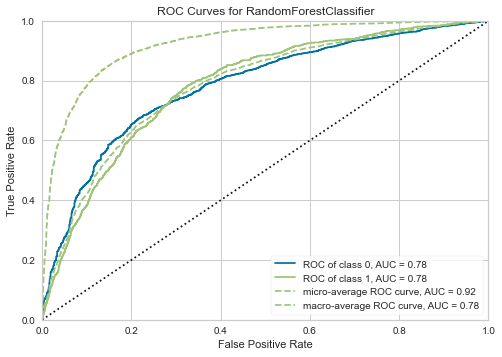

In [82]:
# plot the area under the curve(AUC) for random forrest
plot_model(tuned_rf, plot = 'auc')

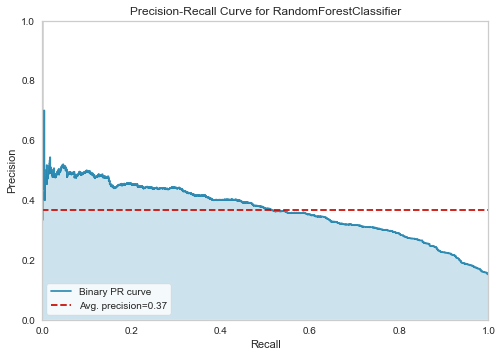

In [83]:
# plot the precesion recall curve 
plot_model(tuned_rf, plot = 'pr')

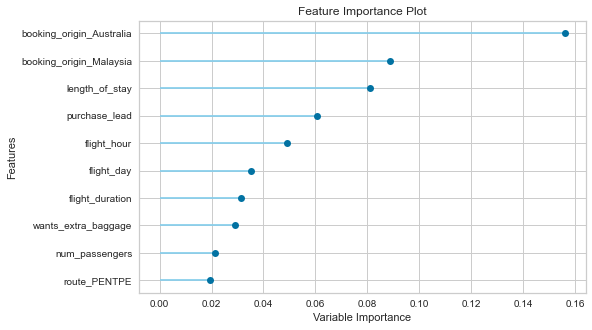

In [84]:
# feature importance 
plot_model(tuned_rf, plot='feature')

In [85]:
# model evaluation
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [89]:
# finalize the model and save 
final_rf = finalize_model(tuned_rf)
# save the model to pickle file 
pickle.dump(final_rf, open("models/random_forest.pkl", 'wb'))
print("MODEL SAVED!")

MODEL SAVED!
